In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv("train_clean.csv").drop(columns="Unnamed: 0")

y = df.severity
X = df.drop(columns='severity')

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"Train size: {len(y_train)} - Test size: {len(y_test)}")

Train size: 34375 - Test size: 11459


## Model Selection

Models to test:
- KNN
- SVC (RBF)
- Random Forest
- Naive bayes
- XGBClassifier

In [3]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

### First runs

In [3]:
knn = KNeighborsClassifier(10)

In [4]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [5]:
y_pred = knn.predict(X_test)
y_scores = knn.predict_proba(X_test)

In [6]:
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

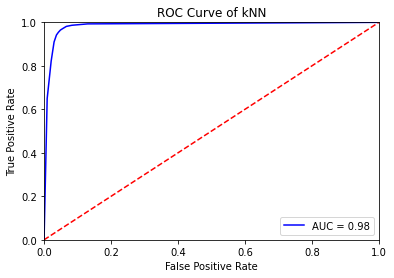

In [7]:
# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7035
           1       0.93      0.95      0.94      4424

    accuracy                           0.96     11459
   macro avg       0.95      0.96      0.95     11459
weighted avg       0.96      0.96      0.96     11459



### Cross-validation & Grid Search

In [13]:
knn_cv = KNeighborsClassifier()

param_grid = {'n_neighbors': range(5, 22, 2)}

In [14]:
knn_gscv = GridSearchCV(knn_cv, param_grid, cv=15, verbose=2)

In [15]:
#fit model to data
knn_gscv.fit(X_train, y_train)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.3s
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.2s
[CV] END ......................................n_neighbors=5; total time=   1.1s
[CV] END ......................................n_neighbors=5; total time=   1.1s
[CV] END ......................................n_neighbors=5; total time=   1.1s
[CV] END ......................................

GridSearchCV(cv=15, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 22, 2)}, verbose=2)

In [16]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 5}

In [17]:
knn_gscv.best_score_

0.9586324081205029

In [18]:
bknn = knn_gscv.best_estimator_

In [19]:
y_pred_cv = bknn.predict(X_test)
y_score_cv = bknn.predict_proba(X_test)

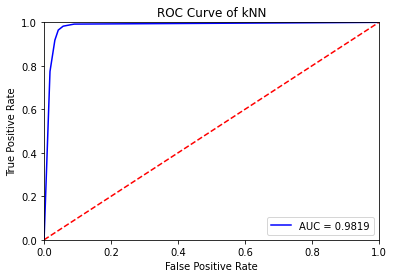

In [22]:
fpr, tpr, threshold = roc_curve(y_test, y_score_cv[:, 1])
roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [21]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7074
           1       0.93      0.96      0.95      4385

    accuracy                           0.96     11459
   macro avg       0.96      0.96      0.96     11459
weighted avg       0.96      0.96      0.96     11459



### Other Models

In [24]:
classifiers = {
    "knn": KNeighborsClassifier(),
    "svc": SVC(),
    "r_forest": RandomForestClassifier(),
    "naive_bayes": GaussianNB(),
    "xgbc": XGBClassifier,
}

In [25]:
grids = {
    "knn": {
        "n_neighbors": range(4,21,2),
    },
    "svc": {
        "C": [1, 2],
        "kernel": ['rbf', 'sigmoid'],
        "class_weight": [None, "balanced"],
    },
    "r_forest": {
        "n_estimators": [100, 200, 400, 600, 1000, 1400, 1800, 2400],
        "n_jobs": [-1]
    },
    "xgbc": {
        "n_estimators": [100, 200, 400, 600, 1000, 1400, 1800, 2400],
        "n_jobs": [-1]
    }
}

In [26]:
svc = GridSearchCV(classifiers['svc'], grids['svc'], cv=15, verbose=2)

In [27]:
xgb = classifiers["xgbc"](n_jobs=-1)

In [28]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

In [29]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [31]:
xgb_pred = xgb.predict(X_test)
xgb_scores = xgb.predict_proba(X_test)

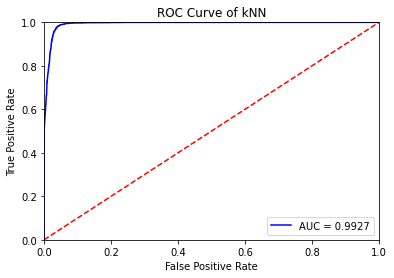

In [33]:
fpr, tpr, threshold = roc_curve(y_test, xgb_scores[:, 1])
roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [32]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7074
           1       0.95      0.97      0.96      4385

    accuracy                           0.97     11459
   macro avg       0.96      0.97      0.97     11459
weighted avg       0.97      0.97      0.97     11459

